In [1]:
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import gsw
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 10)
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['axes.titlesize'] = 20
matplotlib.rcParams['legend.fontsize'] = 16

In [2]:
%run plot.py
%run preprocessing.py
%run thermodynamics.py
%run geometry.py

## Open results from netCDF files
The structure functions have been previously computed and stored into netCDF files.

In [3]:
path = "/data/RESULTS/STRUCTURE_FUNCTIONS/SURFACE_TRACERS/"

In [4]:
D2_ECAL = xr.open_dataset(path + 'ECAL_tracer_structure_function.nc')
D2_NCAL = xr.open_dataset(path + 'NCAL_tracer_structure_function.nc')
D2_SCAL = xr.open_dataset(path + 'SCAL_tracer_structure_function.nc')

In [5]:
profiles = xr.open_dataset('/data/RESULTS/VERTICAL_PROFILES/Mean_ARGO_profiles_around_New_Caledonia.nc')

In [6]:
def get_cool_and_hot_seasons(data, avg_dim='time'):
    data_by_season = data.groupby('time.season').mean(avg_dim).compute()
    # Cool season: from May to September
    data_cool = data_by_season.sel(season=['JJA', 'SON']).mean('season')    
    # Hot season: from November to April
    data_hot = data_by_season.sel(season=['DJF', 'MAM']).mean('season')
    return data_cool, data_hot

## Define plotting functions

In [7]:
def plot_sf_by_month(D2, var='SST', ylim=[0, 500]):
    D2_by_season = D2.groupby('time.month').median('segment')
    print(D2_by_season)
    for mth in D2_by_season.month:
        plot_structure_function(D2_by_season.sel(month=mth), var=var, label=mth.data)
    plt.legend()

In [8]:
def plot_structure_function(D2, var='SST', r_slice=slice(3, 1e2), label='', lw=3,
                            linestyle='-', **kwargs):
    """
    Basic function to plot sedonc order structure functions
    
    Parameters
    ----------
    
    D2 : xarray.Dataset
        A Dataset containing the second order structure functions
    var : {'SST', 'SSS', 'SSrho'}, optional
        Surface variable to plot
    r_slice : slice, optional
        Slice object used to precise the range of scale over which a power law
        will be fitted
    label : str, optional
        Label associated with the plot
    ** kwargs : keyword arguments, optional
        Matplotlib keyword arguments
    
    Returns
    -------
    scale_factor : float
        The offset of the fitted power law        
    """
    from xscale.spectral.tools import fit_power_law, plot_power_law 
    D2_subset = D2.sel(r_bins=r_slice).median('segment')
    power, scale_factor = fit_power_law(D2_subset['r_bins'], D2_subset['D2%s'%var])
    plot_with_bootstrap(D2['D2%s'%var], label=r"%s, $r^{%0.2f}$" %(label, power), 
                        linestyle=linestyle, lw=lw, **kwargs)
    return scale_factor

In [9]:
def plot_normalized_sf_hot_vs_cool(D2, xlim=[1, 1e3], **kwargs):
    import copy
    D2_norm = copy.copy(D2)
    D2_norm['D2SST'] = D2_norm['D2SST'] * D2_norm['alpha'] ** 2
    D2_norm['D2SSS'] = D2_norm['D2SSS'] * D2_norm['beta'] ** 2
    D2_norm['D2SSrho'] = D2_norm['D2SSrho'] / 1025. ** 2
    D2_by_season = dict(D2_norm.groupby('time.season'))
    D2_winter = xr.auto_combine([D2_by_season['JJA'], D2_by_season['SON']])
    D2_summer = xr.auto_combine([D2_by_season['DJF'], D2_by_season['MAM']])
    plot_structure_function(D2_winter, var='SST', label=r'$SST$ Cool', 
                            color='C0', alpha=0.15, hatch='||||')
    plot_structure_function(D2_summer, var='SST', label=r'$SST$ Warm', 
                                color='C0', alpha=0.15, linestyle='--', hatch='----')
    plot_structure_function(D2_winter, var='SSS', label=r'$SSS$ Cool', 
                            color='C3', alpha=0.15, hatch='||||')
    plot_structure_function(D2_summer, var='SSS', label=r'$SSS$ Warm', 
                                color='C3', alpha=0.15, linestyle='--', hatch='----')
    plot_structure_function(D2_winter, var='SSrho', label=r'$SS\rho$ Cool', 
                            color='C2', alpha=0.15, hatch='||||')
    plot_structure_function(D2_summer, var='SSrho', label=r'$SS\rho$ Warm', 
                                color='C2', alpha=0.15, linestyle='--', hatch='----')
    plt.xlabel(r'$r(km)$')
    plt.ylabel(r'$D2$')
    plt.xlim(xlim)
    plt.grid(which='both')
    plt.legend(loc="upper left")

In [10]:
def plot_normalized_GM(profiles, region='NCAL', season='Warm', **kwargs):
    import gm
    rho_0 = 1025.
    ax = plt.gca()
    r = xr.IndexVariable('r', np.logspace(2, 6, 401))
    profile = profiles.sel(region=region, season=season)   
    omega_earth = 7.2921e-5
    f = 2 * omega_earth * np.sin(np.pi / 180. * profile.lat_mean)
    N = profile.N.sel(p_mid=slice(5, 10)).mean('p_mid')
    D2_GM = gm.drhorho_r(r, f=abs(f), N=N, N0=profile.N0, b=abs(profile.b))
    ax.loglog(1e-3 * r, D2_GM / rho_0, lw=2, color='black', label=('GM81 %s' % season), **kwargs)

In [11]:
def plot_sf_ratio(D2, xlim=[1, 1e3], label='', **kwargs):
    R = D2['alpha'] / D2['beta'] * np.sqrt(D2['D2SST'] / D2['D2SSS'])
    R_by_season = R.groupby('time.season').median('segment')
    R_winter = R_by_season.sel(season=['JJA', 'SON']).mean('season')
    R_summer = R_by_season.sel(season=['DJF', 'MAM']).mean('season')
    plt.loglog(R['r_bins'], R_winter, label= "%s Cool" % label, **kwargs)
    plt.loglog(R['r_bins'], R_summer, ls='--', label= "%s Warm" % label, **kwargs)
    plt.xlabel(r'$r(km)$')
    plt.ylabel(r'$|R_\rho|$')
    plt.xlim(xlim)
    plt.ylim([0.5, 10])
    plt.grid(which='both')
    plt.hlines(1, xlim[0], xlim[1], lw=2)
    plt.legend()

In [12]:
def plot_potential_energy_summer_vs_winter(D2, profiles, region, xlim=[1, 1e3], **kwargs):
    import copy
    N_warm = profiles.N.sel(p_mid=slice(5, 10)).mean('p_mid').sel(region=region, season='Warm')
    N_cool = profiles.N.sel(p_mid=slice(5, 10)).mean('p_mid').sel(region=region, season='Cool')
    D2SSb = D2['D2SSrho'] / 1025. ** 2 * 9.81 ** 2
    D2SSb_by_season = D2SSb.groupby('time.season').median('segment')
    D2pe_winter = 1. / N_cool ** 2 *  D2SSb_by_season.sel(season=['JJA', 'SON']).mean('season')
    D2pe_summer =  1. / N_warm ** 2 * D2SSb_by_season.sel(season=['DJF', 'MAM']).mean('season')
    plt.loglog(D2pe_winter['r_bins'], D2pe_winter, label=("%s Cool" % region), **kwargs)
    plt.loglog(D2pe_summer['r_bins'], D2pe_summer, label=("%s Warm" % region), ls='--', **kwargs)
    plt.xlabel(r'$r(km)$')
    plt.ylabel(r'$D2\,(m^2.s^{-2})$')
    plt.xlim(xlim)
    plt.grid(which='both')
    plt.legend(loc="upper left")

## Figure 5: Seasonality of temperature, salinity and density structure functions
After having seen that there is a strong difference between summer and winter months in terms of structure functions, we plot the normalized structure functions for each season.

/Users/serazin/anaconda3/envs/jplab/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/Users/serazin/anaconda3/envs/jplab/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/Users/serazin/anaconda3/envs/jplab/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/Users/serazin/anaconda3/envs/jplab/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/Users/serazin/anaconda3/envs/jplab/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/Users/serazin/anaconda3/envs/jplab/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolat

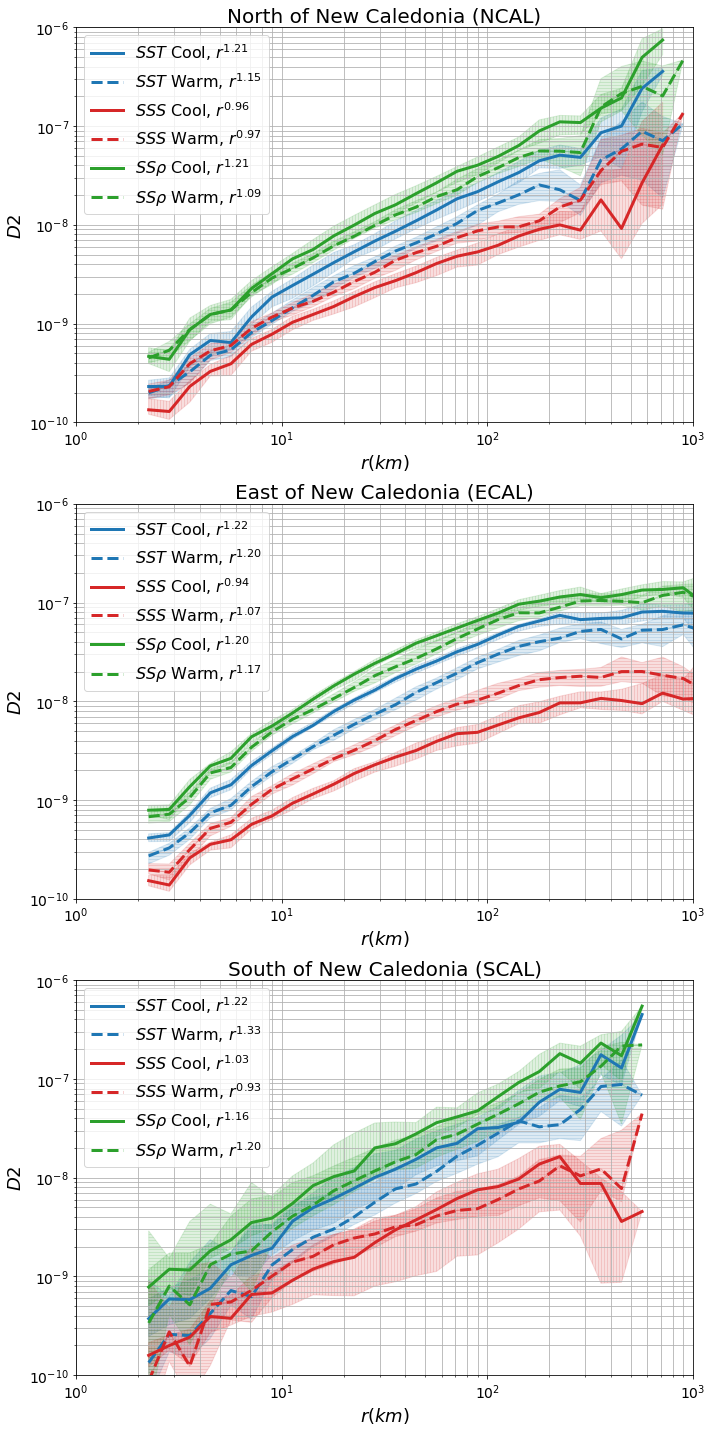

In [13]:
plt.figure(figsize=(10, 20))
plt.subplot(311)
plot_normalized_sf_hot_vs_cool(D2_NCAL, lw=2)
#plot_normalized_GM(profiles, region='NCAL', season='Cool')
#plot_normalized_GM(profiles, region='NCAL', season='Warm', ls='--')
plt.ylim([1e-10, 1e-6])
plt.title('North of New Caledonia (NCAL)')
plt.subplot(312)
plot_normalized_sf_hot_vs_cool(D2_ECAL, lw=2)
#plot_normalized_GM(profiles, region='ECAL', season='Cool')
#plot_normalized_GM(profiles, region='ECAL', season='Warm', ls='--')
plt.ylim([1e-10, 1e-6])
plt.title('East of New Caledonia (ECAL)')
plt.subplot(313)
plot_normalized_sf_hot_vs_cool(D2_SCAL, lw=2)
plt.title('South of New Caledonia (SCAL)')
#plot_normalized_GM(profiles, region='SCAL', season='Cool')
#plot_normalized_GM(profiles, region='SCAL', season='Warm', ls='--')
plt.ylim([1e-10, 1e-6])
plt.tight_layout()
plt.savefig('../Figures/Fig_5_tracer_structure_functions.png', dpi=300, bbox_inches='tight')

## Figure 7a: Potential Energy structure function

/Users/serazin/anaconda3/envs/jplab/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/Users/serazin/anaconda3/envs/jplab/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/serazin/anaconda3/envs/jplab/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/Users/serazin/anaconda3/envs/jplab/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/serazin/anaconda3/envs/jplab/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/Users/serazin/anaconda3/envs/jplab/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dt

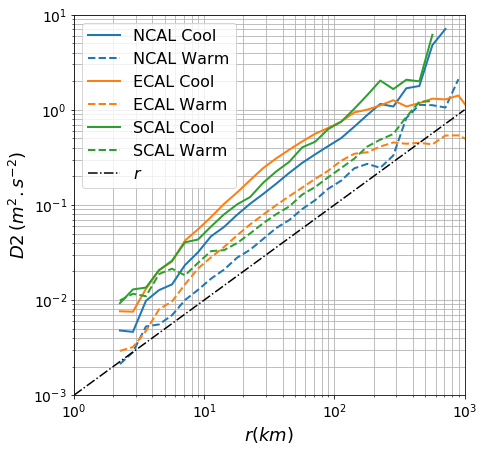

In [14]:
plt.figure(figsize=(7, 7))
from xscale.spectral.tools import plot_power_law 
scale_factor = 1e-3
plot_potential_energy_summer_vs_winter(D2_NCAL, profiles, region='NCAL', color='C0', lw=2)
plot_potential_energy_summer_vs_winter(D2_ECAL, profiles, region='ECAL', color='C1', lw=2)
plot_potential_energy_summer_vs_winter(D2_SCAL, profiles, region='SCAL', color='C2', lw=2)
plot_power_law(1., scale_factor, ls='-.', lw=1.5, color='black', label=r'$r$')
plt.legend()
plt.xlim([0, 1000])
plt.ylim([1e-3, 1e1])
plt.savefig('../Figures/Fig_7a-Potential_Energy.png', dpi=300, bbox_inches='tight')

## Figure 7b: density ratio computed from structure functions

/Users/serazin/anaconda3/envs/jplab/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/Users/serazin/anaconda3/envs/jplab/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/serazin/anaconda3/envs/jplab/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/Users/serazin/anaconda3/envs/jplab/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/serazin/anaconda3/envs/jplab/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/Users/serazin/anaconda3/envs/jplab/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dt

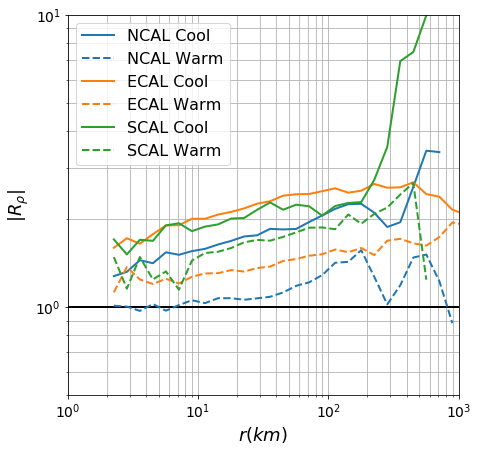

In [15]:
plt.figure(figsize=(7, 7))
plot_sf_ratio(D2_NCAL, label='NCAL', color='C0', lw=2)
plot_sf_ratio(D2_ECAL, label='ECAL', color='C1', lw=2)
plot_sf_ratio(D2_SCAL, label='SCAL', color='C2', lw=2)
plt.savefig('../Figures/Fig_7b-density_ratio.png', dpi=300, bbox_inches='tight')

In [18]:
%%system
montage ../Figures/Fig_7b*.png ../Figures/Fig_7a*.png -geometry 1024x2048 -tile 2x1 -quality 100 ../Figures/Fig_7-PE_and_density_ratio.png
convert ../Figures/Fig_7-PE_and_density_ratio.png -trim -bordercolor White -border 20x10 +repage ../Figures/Fig_7-PE_and_density_ratio.png

[]

## Seasonality of surface tracer structure functions East of New Caledonia

NameError: name 'plot_sf_by_season' is not defined

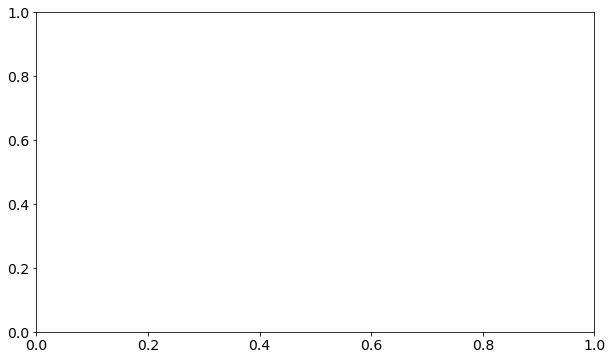

In [19]:
plt.figure(figsize=(10, 20))
ax1 = plt.subplot(311)
plot_sf_by_season(D2_ECAL, var='SST')
ax2 = plt.subplot(312)
plot_sf_by_season(D2_ECAL, var='SSS')
ax3 = plt.subplot(313)
plot_sf_by_season(D2_ECAL, var='SSrho')

## Seasonality of surface tracer structure functions North of New Caledonia

In [ ]:
plt.figure(figsize=(10, 20))
ax1 = plt.subplot(311)
plot_sf_by_season(D2_NCAL, var='SST')
ax2 = plt.subplot(312)
plot_sf_by_season(D2_NCAL, var='SSS')
ax3 = plt.subplot(313)
plot_sf_by_season(D2_NCAL, var='SSrho')

## Seasonality of surface tracer structure functions South of New Caledonia

In [ ]:
plt.figure(figsize=(10, 20))
ax1 = plt.subplot(311)
plot_sf_by_season(D2_SCAL, var='SST')
ax2 = plt.subplot(312)
plot_sf_by_season(D2_SCAL, var='SSS')
ax3 = plt.subplot(313)
plot_sf_by_season(D2_SCAL, var='SSrho')